In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import re
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.model_selection import GridSearchCV
import datetime 

In [2]:
data = pd.read_csv("train.csv")
data.shape

C:\Users\eric_\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


(509762, 49)

In [3]:
num_cols = data._get_numeric_data().columns
num_cols.shape

(25,)

In [4]:
data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection'],
      dtype='object')

In [5]:
#counting the nulls for each column
missing = sum(data.isnull().values)
cols = list(data)
#creating a dataframe that has column name and amount missing sorted in descending order
nan_df = pd.DataFrame()
nan_df["cols"] = cols
nan_df["missing"] = missing
#grabs top 10 columns with na's 
nan_df.sort_values(by = ['missing'], ascending = False).head(10)

,cols,missing
48,WindDirection,80234
47,WindSpeed,67430
45,Temperature,48532
44,GameWeather,43648
42,StadiumType,32934
20,FieldPosition,6424
46,Humidity,6160
24,OffenseFormation,110
26,DefendersInTheBox,66
8,Orientation,18


In [6]:
#creates a column that says 1 if home team has possession 0 if away team has possession
Possession_HomeTM = []
#creates a column that says if 1 they are the home team if 0 they are the away team
IsHomeTM = []
for i,j in enumerate(data['PossessionTeam']):
    if j == data['HomeTeamAbbr'][i]:
        Possession_HomeTM.append(1)
        IsHomeTM.append(1)
    else:
        Possession_HomeTM.append(0)
        IsHomeTM.append(0)
data['Possession_HomeTM'] = Possession_HomeTM
data['IsHomeTM'] = IsHomeTM

In [7]:
#creates a column that says 1 if the ball is on the home side of the field and zero if the ball is on the away side
FieldPosition_HomeTM = []
for i,j in enumerate(data['FieldPosition']):
    if j == data['HomeTeamAbbr'][i]:
        FieldPosition_HomeTM.append(1)
    else:
        FieldPosition_HomeTM.append(0)
data['FieldPosition_HomeTM'] = FieldPosition_HomeTM

In [8]:
#converts OffensePersonnel and DefensePersonnel from string to numeric columns based on number of WR, QB etc on the field
def num_cont_format(position, data_col, off_or_def):
    num_of_temp = []
    #finds the positon of the string I typed in, for exmaple if I tyed in WR it would retun the position where the 'W' is
    data_pos = data_col.str.find(position)
    # I subrct 2 spaces so that I have number of WR's or QB's or whatever I typed in 
    data_num = data_pos - 2
    for i, j in enumerate(data_col):
        #appends the number of  WR's or QB's or whatever I typed in to a list, if nothing is there it appends a blank
        num_of_temp.append(data_col[i][data_num[i]])
    if off_or_def == 'off':
        data["OffPersonnel" + position] = num_of_temp
                           
    else:
        data["DefPersonnel" + position] = num_of_temp
    
        
num_cont_format("WR",data['OffensePersonnel'], 'off')
num_cont_format("QB",data['OffensePersonnel'], 'off')
num_cont_format("RB",data['OffensePersonnel'], 'off')
num_cont_format("TE",data['OffensePersonnel'], 'off')
num_cont_format("DB",data['OffensePersonnel'], 'off')
num_cont_format("DL",data['OffensePersonnel'], 'off')
num_cont_format("LB",data['OffensePersonnel'], 'off')
num_cont_format("QB",data['OffensePersonnel'], 'off')
num_cont_format("OL",data['OffensePersonnel'],'off')
num_cont_format("DL",data['DefensePersonnel'],'def')
num_cont_format("LB",data['DefensePersonnel'],'def')
num_cont_format("DB",data['DefensePersonnel'],'def')
num_cont_format("OL",data['DefensePersonnel'],'def')

In [9]:
#Replaces blanks with a number that I choose
data['OffPersonnelQB'].replace(r'^\s*$', 1, regex=True, inplace = True)
data['OffPersonnelDB'].replace(r'^\s*$', 0, regex=True, inplace = True)
data['OffPersonnelDL'].replace(r'^\s*$', 0, regex=True, inplace = True)
data['OffPersonnelLB'].replace(r'^\s*$', 0, regex=True, inplace = True)
data['OffPersonnelOL'].replace(r'^\s*$', 5, regex=True, inplace = True)
data['DefPersonnelOL'].replace(r'^\s*$', 0, regex=True, inplace = True)
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,OffPersonnelRB,OffPersonnelTE,OffPersonnelDB,OffPersonnelDL,OffPersonnelLB,OffPersonnelOL,DefPersonnelDL,DefPersonnelLB,DefPersonnelDB,DefPersonnelOL
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,1,1,0,0,0,5,2,3,6,0
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,1,1,0,0,0,5,2,3,6,0
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,1,1,0,0,0,5,2,3,6,0
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,1,1,0,0,0,5,2,3,6,0
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,1,1,0,0,0,5,2,3,6,0


In [10]:
#converts columns from string to int
data['OffPersonnelWR'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelQB'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelRB'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelTE'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelDB'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelDL'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelLB'] = data['OffPersonnelWR'].astype('int')
data['OffPersonnelOL'] = data['OffPersonnelWR'].astype('int')
data['DefPersonnelDL'] = data['DefPersonnelDL'].astype('int')
data['DefPersonnelLB'] = data['DefPersonnelLB'].astype('int')
data['DefPersonnelDB'] = data['DefPersonnelDB'].astype('int')
data['DefPersonnelOL'] = data['DefPersonnelOL'].astype('int')

In [11]:
#converts height in in feet and inches to just inches
height_inches = []
for i, j in enumerate(data["PlayerHeight"]):
    #takes the first element of PlayerHeight, how tall the player is in feet, mulitples * 12 and adds the 3rd element
    #inches
    height_inches.append(int(data["PlayerHeight"][i][0]) * 12 + int(data["PlayerHeight"][i][2]))
data["PlayerHeightInches"] = height_inches


In [12]:
data.head()

,GameId,PlayId,Team,X,Y,S,A,Dis,Orientation,Dir,...,OffPersonnelTE,OffPersonnelDB,OffPersonnelDL,OffPersonnelLB,OffPersonnelOL,DefPersonnelDL,DefPersonnelLB,DefPersonnelDB,DefPersonnelOL,PlayerHeightInches
0,2017090700,20170907000118,away,73.91,34.84,1.69,1.13,0.40,81.99,177.18,...,3,3,3,3,3,2,3,6,0,72
1,2017090700,20170907000118,away,74.67,32.64,0.42,1.35,0.01,27.61,198.70,...,3,3,3,3,3,2,3,6,0,75
2,2017090700,20170907000118,away,74.00,33.20,1.22,0.59,0.31,3.01,202.73,...,3,3,3,3,3,2,3,6,0,75
3,2017090700,20170907000118,away,71.46,27.70,0.42,0.54,0.02,359.77,105.64,...,3,3,3,3,3,2,3,6,0,75
4,2017090700,20170907000118,away,69.32,35.42,1.82,2.43,0.16,12.63,164.31,...,3,3,3,3,3,2,3,6,0,72


In [13]:
#finds the unique stirngs in StadiumType
data['StadiumType'].unique()

array(['Outdoor', 'Outdoors', 'Indoors', 'Retractable Roof', 'Indoor',
       'Retr. Roof-Closed', 'Open', nan, 'Indoor, Open Roof',
       'Retr. Roof - Closed', 'Outddors', 'Dome', 'Domed, closed',
       'Indoor, Roof Closed', 'Retr. Roof Closed',
       'Outdoor Retr Roof-Open', 'Closed Dome', 'Oudoor', 'Ourdoor',
       'Dome, closed', 'Retr. Roof-Open', 'Heinz Field', 'Outdor',
       'Retr. Roof - Open', 'Domed, Open', 'Domed, open', 'Cloudy',
       'Bowl', 'Outside', 'Domed'], dtype=object)

In [14]:
#converts StatiumType to a binary column, 1 if outdoor statium 0 if indoor stadium
OutdoorStadium = []
for i, j in enumerate(data["StadiumType"]):
    if (j == 'Outdoor' or j =='Outdoors' or j == 'Retractable Roof' or j == 'Open' or j == 'Indoor, Open Roof' or
        j == 'Outddors' or j == 'Outdoor Retr Roof-Open' or j == 'Oudoor' or j == 'Ourdoor' or j == 'Retr. Roof-Open' or
        j == 'Heinz Field' or j == 'Outdor' or j == 'Retr. Roof - Open' or j == 'Domed, Open' or j == 'Domed, open' or
        j == 'Bowl' or j == 'Outside'):
        OutdoorStadium.append(1)
    elif (j == np.nan or j == 'Cloudy'):
         OutdoorStadium.append(np.nan)
    else:
        OutdoorStadium.append(0)
data['OutdoorStadium'] = OutdoorStadium

In [15]:
data.columns

Index(['GameId', 'PlayId', 'Team', 'X', 'Y', 'S', 'A', 'Dis', 'Orientation',
       'Dir', 'NflId', 'DisplayName', 'JerseyNumber', 'Season', 'YardLine',
       'Quarter', 'GameClock', 'PossessionTeam', 'Down', 'Distance',
       'FieldPosition', 'HomeScoreBeforePlay', 'VisitorScoreBeforePlay',
       'NflIdRusher', 'OffenseFormation', 'OffensePersonnel',
       'DefendersInTheBox', 'DefensePersonnel', 'PlayDirection', 'TimeHandoff',
       'TimeSnap', 'Yards', 'PlayerHeight', 'PlayerWeight', 'PlayerBirthDate',
       'PlayerCollegeName', 'Position', 'HomeTeamAbbr', 'VisitorTeamAbbr',
       'Week', 'Stadium', 'Location', 'StadiumType', 'Turf', 'GameWeather',
       'Temperature', 'Humidity', 'WindSpeed', 'WindDirection',
       'Possession_HomeTM', 'IsHomeTM', 'FieldPosition_HomeTM',
       'OffPersonnelWR', 'OffPersonnelQB', 'OffPersonnelRB', 'OffPersonnelTE',
       'OffPersonnelDB', 'OffPersonnelDL', 'OffPersonnelLB', 'OffPersonnelOL',
       'DefPersonnelDL', 'DefPersonnelLB', 'Def

In [16]:
#finds the unique strings in Turf
data['Turf'].unique()

array(['Field Turf', 'A-Turf Titan', 'Grass', 'UBU Sports Speed S5-M',
       'Artificial', 'DD GrassMaster', 'Natural Grass',
       'UBU Speed Series-S5-M', 'FieldTurf', 'FieldTurf 360',
       'Natural grass', 'grass', 'Natural', 'Artifical', 'FieldTurf360',
       'Naturall Grass', 'Field turf', 'SISGrass',
       'Twenty-Four/Seven Turf', 'natural grass'], dtype=object)

In [17]:
#converts Turf type to 1 if if turf and 0 if grass
IsTurf = []
for i, j in enumerate(data["Turf"]):
    if (j == 'Grass' or j == 'Natural Grass' or j == 'Natural grass' or j == 'grass' or j == 'Natural' or
        j == 'Naturall Grass' or j == 'SISGrass' or j == 'natural grass'):
        IsTurf.append(0)
    else:
        IsTurf.append(1)
data['IsOnTurf'] = IsTurf

In [18]:
#converts to lowercase
data['GameWeather'] = data['GameWeather'].str.lower()
#finds the unique strings in GameWeather 
data['GameWeather'].unique()

array(['clear and warm', 'sun & clouds', 'sunny', 'controlled climate',
       'mostly sunny', 'clear', nan, 'indoor', 'mostly cloudy',
       'mostly coudy', 'partly sunny', 'partly cloudy', 'cloudy',
       'sunny, highs to upper 80s', 'indoors', 'light rain', 'showers',
       '30% chance of rain',
       'cloudy with periods of rain, thunder possible. winds shifting to wnw, 10-20 mph.',
       'rain', 'cloudy, fog started developing in 2nd quarter', 'coudy',
       'rain likely, temps in low 40s.', 'cold', 'n/a (indoors)',
       'clear skies', 'fair', 'cloudy, chance of rain',
       'heavy lake effect snow', 'party cloudy',
       'cloudy, light snow accumulating 1-3"', 'cloudy and cold', 'snow',
       'hazy', 'scattered showers', 'cloudy and cool', 'n/a indoor',
       'rain chance 40%', 'clear and sunny', 'sunny and warm',
       'partly clear', 'cloudy, 50% change of rain', 'sunny, windy',
       'clear and cool', 'sunny and clear', 'mostly sunny skies',
       'partly clouid

In [19]:
#converts GameWeather to either rainy, snowy or clear from the 20 or 30 strings above
GameWeather_simple = []
for i, j in enumerate(data["GameWeather"]):
    #if rain or showers is in one of the unique strings above the new column becomes rainy 
    if (str(data["GameWeather"][i]).find("rain") != -1 or str(data["GameWeather"][i]).find("showers") != -1):
        GameWeather_simple.append("Rainy")
    #if snow is in one of the unique strings above the new column becomes snowy
    elif str(data["GameWeather"][i]).find("snow") != -1:
        GameWeather_simple.append("Snowy")
    else:
    #if does not match one of the two conditions above it is clear which means no snow or rain
        GameWeather_simple.append("Clear")
data['GameWeather_simple'] = GameWeather_simple

In [20]:
#grabs year from the PlayerBirthDate string
birthdate = data['PlayerBirthDate'].str.split('/', expand = True)
data["PlayerYearBorn"] = birthdate[2]
#converts to int
data['PlayerYearBorn'] = data['PlayerYearBorn'].astype('int')

In [21]:
#splits GameClock into 3 columns by :
game_clock = data['GameClock'].str.split(':', expand = True)

In [22]:
#just keeps min and second and reforms into decimal with min as the interger and second as the decimal
game_clock1 = game_clock[0] + '.' + game_clock[1]
data['GameClock_reform'] = game_clock1.astype('float')

In [23]:
#creates TeamName column if Team == HomeTeam
TeamName = []
for i, j in enumerate(data["Team"]):
    if j == 'home':
        TeamName.append(data['HomeTeamAbbr'][i])
    else:
        TeamName.append(data['VisitorTeamAbbr'][i])
data['TeamName'] = TeamName
    

In [24]:
#finds the unique strings in WindSpeed
data['WindSpeed'].unique()

array([8.0, 6.0, 10.0, 9.0, 11.0, nan, 7.0, 5.0, 2.0, 12.0, 1, 3, 4, 13,
       '10', '5', '6', '4', '8', '0', 'SSW', 14.0, 0.0, 15.0, 17.0, 18.0,
       16.0, '11-17', '16', '14', '13', '12', '23', '7', '9', '3', '17',
       '14-23', '1', '13 MPH', 24.0, '15', '12-22', '2', '4 MPh',
       '15 gusts up to 25', '11', '10MPH', '10mph', '22', 'E', '7 MPH',
       'Calm', '6 mph', '19', 'SE', '20', '10-20', '12mph'], dtype=object)

In [25]:
#creates Wind column that converts the strings above to nunmeric data
Wind = []
for i, j in enumerate(data["WindSpeed"]):
    if (j == 'SSW' or j == 'SE' or j == 'Calm' or j == "E"):
        Wind.append(np.nan)
    elif j == '11-17':
        Wind.append(14)
    elif j == '14-23':
        Wind.append(18.5)
    elif j == '10-20':
        Wind.append(15)
    elif j == '12-22':
        Wind.append(17)
    elif j == '15 gusts up to 25':
        Wind.append(15)
    else:
    #just keeps if a number or decimal place eliminates the rest
        temp = re.sub('[^0-9.]','', str(j))
        Wind.append(temp)
data['WindSpeed_reform'] = Wind
        
    
    
        

In [26]:
#replaces blanks with nan
data.replace(r'^\s*$', np.nan, regex=True, inplace = True)
data['WindSpeed_reform'].unique()

array(['8.0', '6.0', '10.0', '9.0', '11.0', nan, '7.0', '5.0', '2.0',
       '12.0', '2', '5', '6', '10', '7', '1', '3', '12', '4', '13', '8',
       '0', '3.0', '14.0', '0.0', '13.0', '4.0', '1.0', '15.0', '17.0',
       '18.0', '16.0', 14, '16', '14', '23', '9', '17', 18.5, '24.0',
       '15', 17, 15, '11', '22', '19', '20'], dtype=object)

In [27]:
#converts strings of numbers or float
data['WindSpeed_reform'] = data['WindSpeed_reform'].astype(float)

In [28]:
#drops useless columns or columns that I allready recreated
data.drop(["PlayId","GameId", "NflId", "DisplayName", "JerseyNumber", "PlayerCollegeName", "TimeHandoff","TimeSnap", 
        "HomeTeamAbbr", "VisitorTeamAbbr","Location", "Turf", "GameWeather", "PlayerBirthDate",
           "GameClock", "Team", "StadiumType", "PlayerHeight", "DefensePersonnel", "OffensePersonnel", "PossessionTeam",
           "FieldPosition", "Stadium", "NflIdRusher", "WindDirection", "WindSpeed"], axis = 1, inplace = True)


In [29]:
#converts remaining categorical columns to binary columns
data = pd.get_dummies(data)
data.shape

(509762, 111)

In [30]:
data.head()

,X,Y,S,A,Dis,Orientation,Dir,Season,YardLine,Quarter,...,TeamName_NYG,TeamName_NYJ,TeamName_OAK,TeamName_PHI,TeamName_PIT,TeamName_SEA,TeamName_SF,TeamName_TB,TeamName_TEN,TeamName_WAS
0,73.91,34.84,1.69,1.13,0.40,81.99,177.18,2017,35,1,...,0,0,0,0,0,0,0,0,0,0
1,74.67,32.64,0.42,1.35,0.01,27.61,198.70,2017,35,1,...,0,0,0,0,0,0,0,0,0,0
2,74.00,33.20,1.22,0.59,0.31,3.01,202.73,2017,35,1,...,0,0,0,0,0,0,0,0,0,0
3,71.46,27.70,0.42,0.54,0.02,359.77,105.64,2017,35,1,...,0,0,0,0,0,0,0,0,0,0
4,69.32,35.42,1.82,2.43,0.16,12.63,164.31,2017,35,1,...,0,0,0,0,0,0,0,0,0,0


In [31]:
#shows me the top 10 columns with na's 
missing = sum(data.isnull().values)
cols = list(data)
nan_df = pd.DataFrame()
nan_df["cols"] = cols
nan_df["missing"] = missing
nan_df.sort_values(by = ['missing'], ascending = False).head(10)

,cols,missing
40,WindSpeed_reform,71632
18,Temperature,48532
19,Humidity,6160
36,OutdoorStadium,770
14,DefendersInTheBox,66
5,Orientation,18
6,Dir,14
77,GameWeather_simple_Rainy,0
74,Position_TE,0
75,Position_WR,0


In [32]:
data_clean = data.dropna()
print(data.shape)
print(data_clean.shape)
data_clean.to_csv("data_clean.csv")

(509762, 111)
(436286, 111)


In [33]:
#drops outliers using 3 different outlier methods
outlier_frac = 0.01 #Fraction of outiers
ell = EllipticEnvelope(contamination=outlier_frac)
iso = IsolationForest(contamination=outlier_frac)
lof = LocalOutlierFactor(contamination=outlier_frac)
ell.fit(data_clean)
iso.fit(data_clean)
pred1 = ell.predict(data_clean)
pred2 = iso.predict(data_clean)
pred3 = lof.fit_predict(data_clean)
pred = pred1 + pred2 + pred3
pred
data_clean1 = np.hstack((data_clean, pred.reshape(436286,1)))
cols = list(data_clean)
data_clean1 = pd.DataFrame(data_clean1, columns = cols+["outliers"], index = data_clean.index)
data_clean1 = data_clean1[(data_clean1["outliers"]==3)]
print(data_clean.shape)
data_clean1.shape

C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\covariance\robust_covariance.py:646: UserWarning: The covariance matrix associated to your dataset is not full rank
  warnings.warn("The covariance matrix associated to your dataset "
C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:223: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)
C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\ensemble\iforest.py:417: DeprecationWarning: threshold_ attribute is deprecated in 0.20 and will be removed in 0.22.
  " be removed in 0.22.", DeprecationWarning)


(436286, 111)


(423578, 112)

In [34]:
#drops outliers
data_clean1.drop(["outliers"], axis = 1, inplace = True)
data_clean1.shape

(423578, 111)

In [35]:
#creates y column and x dataset
y = data_clean1['Yards']
data_clean1.drop(["Yards"], axis = 1, inplace = True)
x = data_clean1

In [36]:
x.shape

(423578, 110)

(array([4.16900e+03, 2.78791e+05, 1.18146e+05, 1.73980e+04, 3.58100e+03,
        8.72000e+02, 1.82000e+02, 1.87000e+02, 1.26000e+02, 1.26000e+02]),
 array([-14. ,  -4.8,   4.4,  13.6,  22.8,  32. ,  41.2,  50.4,  59.6,
         68.8,  78. ]),
 <a list of 10 Patch objects>)

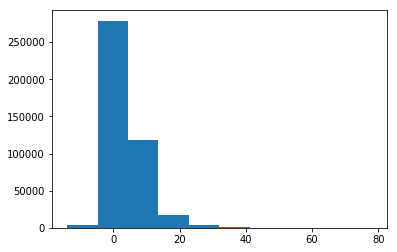

In [37]:
#plots the y column aka yards 
plt.hist(y)

In [38]:
#standardizes the x's, which is not necessary due to using tree based model, but in case I use non tree based models
scaler = StandardScaler()  
scaler.fit(x)
x_scaled = scaler.transform(x)

In [39]:
#converts to numpy
y = y.to_numpy()

In [40]:
#splits train and test data into 80% training and 20% test
x_train, x_test, y_train, y_test = train_test_split(
     x_scaled, y, test_size=0.2, random_state = 99)


In [41]:
#does GridSearch of 4 parameters and finds the best parameters using cross validation of 2
#'max_features':[5,15,25]
#'min_samples_split':[1000,10000], 'min_samples_leaf':[1000,10000]
param_grid_xg = {'learning_rate':[.01,.1],'max_depth':[8,11,13],
             'subsample':[.6,.8], 'colsample_bytree':[.6,.8]}
xg_reg_grid = XGBRegressor(alpha = 1, lamda = 1, n_estimators = 1000)
grid_score = GridSearchCV(estimator = xg_reg_grid, param_grid = param_grid_xg, cv = 2, n_jobs = 3)
grid_score.fit(x_train,y_train)
mod_results = pd.DataFrame.from_dict(grid_score.cv_results_)
print(datetime.datetime.now())

[05:10:07] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
2019-12-03 05:52:17.201295


C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split0_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('split1_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:125: FutureWarning: You are accessing a training score ('mean_train_score'), which will not be available by default any more in 0.21. If you need training scores, please set return_train_score=True
  warnings.warn(*warn_args, **warn_kwargs)
C:\Users\eric_\Anaconda3\lib\site-packages\sklearn\utils\

In [42]:
print(grid_score.best_params_)
print(grid_score.best_score_)

{'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 13, 'subsample': 0.8}
0.9191599409238107


In [43]:
#paremeters are picked from best params above
xg_reg = XGBRegressor(n_estimators = 1000, learning_rate = .1, max_depth = 13, alpha = 1, lamda = 1, 
                          gamma = 0, subsample =.8, colsample_bytree =.8)
#trains model on training data
xg_reg.fit(x_train, y_train)
#predicts on test data
y_pred_xg = xg_reg.predict(x_test)
#r2 score on test data
print(r2_score(y_test,y_pred_xg))
print(datetime.datetime.now())

[05:52:17] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
0.9733170130686749
2019-12-03 06:34:22.175122


In [ ]:
def rf_reg():
    rf_reg = RandomForestRegressor(max_depth = 3, n_estimators=1000)
    rf_reg.fit(x_train, y_train)
    y_pred_RF = rf_reg.predict(x_test)
    return r2_score(y_test, y_pred_RF)
rf_reg()

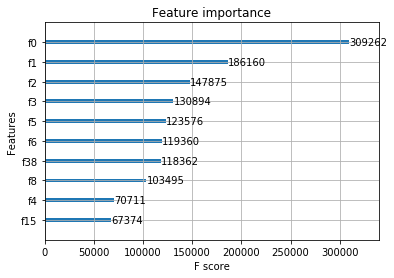

In [44]:
#top ten featues are X,Y,S,A,Dis,Orientation,Season, DefendersInTheBox, IsOnTurf
#top model is twice as dependent on f0 or X than any other column, to me that is not ideal, with more time I would 
#have liked to have the plot below look more linear than like an asymptote, because if this model is deployed and X
#starts to behave differently then my model would no longer be useful, but if I made the graph below more linear then 
#the model would last longer when deployed due to ability to predicted stronger based on other factors
plot_importance(xg_reg, max_num_features=10)
plt.show()

In [45]:
print(np.shape(y_pred_xg))
np.shape(y_test)

(84716,)


(84716,)

In [50]:
#creates two np arrays with all zeros in them
y_pred = np.zeros((84716,200))
y_ans = np.zeros((84716,200))

#creates continuous ranked probability score based on my predictions
for i,p in enumerate(y_pred_xg):
    p += 99
    for j in range(200):
        if j >= p + 10:
            y_pred[i][j] = 1.0
        elif j >= p - 10:
            y_pred[i][j] = (j + 10 - p)*0.05

for i,p in enumerate(y_test):
    p += 99
    for j in range(200):
        if j >= p:
            y_ans[i][j] = 1.0
            
#the rps score, the lower the better
print("rps score:",np.sum(np.power(y_pred - y_ans,2))/(200*(84716)))

rps score: 0.008539063841794942


In [51]:
#creates list of column headings
cols = []
for i in range(-99,100,1):
    cols.append(i)

In [52]:
#converts to df
y_pred_df = pd.DataFrame(data = y_pred[1:,1:], columns = cols) 

In [53]:
#99 should always be one and below it checks out
y_pred_df

,-99,-98,-97,-96,-95,-94,-93,-92,-91,-90,...,90,91,92,93,94,95,96,97,98,99
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
